<a href="https://colab.research.google.com/github/rouchi-11/Image_Processing/blob/main/Assignment_7/Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Upload your dataset folder (zipped) — e.g., flower.zip


Saving archive (5).zip to archive (5) (1).zip
 Dataset extracted to /content/dataset
 Using image: dataset/photos_no_class/bibimbap-gf29abdbf1_640.jpg
 Image shape: (427, 640)

 Processing Quality = 90

 Processing Quality = 70

 Processing Quality = 50

 Processing Quality = 30

 Processing Quality = 10


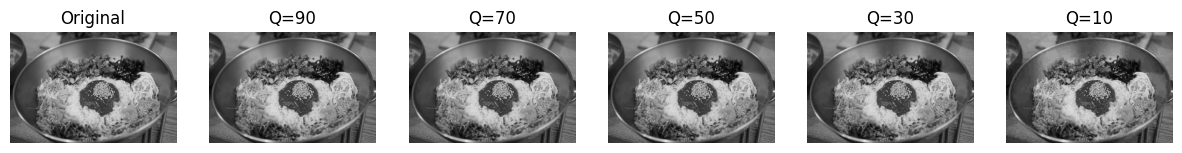


 Compression Results:


,Quality (Q),Compression Ratio,bpp,PSNR,SSIM
0,90,2.526525,3.166404,46.146822,0.996792
1,70,3.929563,2.035850,36.600416,0.971831
2,50,4.637612,1.725026,34.453622,0.956527
3,30,5.316124,1.504856,32.512429,0.934280
4,10,6.581116,1.215599,28.387443,0.832884


In [2]:

!pip install numpy Pillow scipy scikit-image matplotlib pandas


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import dct, idct
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from google.colab import files
import zipfile, os, io, pickle, math, pandas as pd
from collections import Counter, namedtuple

print(" Upload your dataset folder (zipped) — e.g., flower.zip")
uploaded = files.upload()

for fname in uploaded.keys():
    with zipfile.ZipFile(io.BytesIO(uploaded[fname]), 'r') as zip_ref:
        zip_ref.extractall("dataset")
print(" Dataset extracted to /content/dataset")

img_path = None
for root, dirs, files_list in os.walk("dataset"):
    for f in files_list:
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff")):
            img_path = os.path.join(root, f)
            break
    if img_path:
        break

print(" Using image:", img_path)
im = Image.open(img_path).convert('L')  # Convert to grayscale
im_np = np.array(im)
H, W = im_np.shape
print(" Image shape:", im_np.shape)

def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

JPEG_Q50 = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
], dtype=np.float32)

def scaled_quant_matrix(Q):
    if Q < 50:
        scale = 5000 / Q
    else:
        scale = 200 - 2 * Q
    Qm = np.floor((JPEG_Q50 * scale + 50) / 100)
    Qm[Qm == 0] = 1
    return Qm


class HuffmanNode(namedtuple('HuffmanNode', ['freq', 'symbol', 'left', 'right'])):
    __slots__ = ()

def build_huffman_code(symbols):
    freq = Counter(symbols)
    nodes = [HuffmanNode(freq=f, symbol=s, left=None, right=None) for s, f in freq.items()]
    while len(nodes) > 1:
        nodes = sorted(nodes, key=lambda n:(n.freq, str(n.symbol)))
        a, b = nodes.pop(0), nodes.pop(0)
        merged = HuffmanNode(freq=a.freq+b.freq, symbol=None, left=a, right=b)
        nodes.append(merged)
    codebook = {}
    def traverse(node, prefix):
        if node.symbol is not None:
            codebook[node.symbol] = prefix or '0'
            return
        traverse(node.left, prefix+'0')
        traverse(node.right, prefix+'1')
    traverse(nodes[0], '')
    return codebook

def huffman_encode(symbols, codebook):
    bitstr = ''.join(codebook[s] for s in symbols)
    return len(bitstr)


def compress_dct_huffman(img, Q=50, block_size=8):
    H, W = img.shape
    padded = np.pad(img, ((0, block_size - H % block_size), (0, block_size - W % block_size)), mode='constant')
    H2, W2 = padded.shape
    Qmat = scaled_quant_matrix(Q)
    quant_blocks = []
    recon = np.zeros_like(padded, dtype=np.float32)

    for i in range(0, H2, block_size):
        for j in range(0, W2, block_size):
            block = padded[i:i+block_size, j:j+block_size].astype(np.float32) - 128
            d = dct2(block)
            q = np.round(d / Qmat).astype(np.int16)
            quant_blocks.append(q.flatten())

    symbols = np.concatenate(quant_blocks)
    codebook = build_huffman_code(symbols)
    compressed_bits = huffman_encode(symbols, codebook)
    overhead_bits = len(pickle.dumps(codebook)) * 8

    idx = 0
    for i in range(0, H2, block_size):
        for j in range(0, W2, block_size):
            q = quant_blocks[idx].reshape((block_size, block_size))
            d = q * Qmat
            block_rec = idct2(d) + 128
            recon[i:i+block_size, j:j+block_size] = block_rec
            idx += 1

    recon = np.clip(recon[:H, :W], 0, 255).astype(np.uint8)
    total_bits = compressed_bits + overhead_bits
    return recon, total_bits

def metrics(orig, rec, total_bits):
    H, W = orig.shape
    original_bits = H * W * 8
    cr = original_bits / total_bits
    bpp = total_bits / (H * W)
    return cr, bpp, psnr(orig, rec, data_range=255), ssim(orig, rec, data_range=255)


Q_values = [90, 70, 50, 30, 10]
results = []
recons = {}

for Q in Q_values:
    print(f"\n Processing Quality = {Q}")
    rec, total_bits = compress_dct_huffman(im_np, Q)
    cr, bpp, p, s = metrics(im_np, rec, total_bits)
    results.append([Q, cr, bpp, p, s])
    recons[Q] = rec

plt.figure(figsize=(15,3))
plt.subplot(1, len(Q_values)+1, 1)
plt.imshow(im_np, cmap='gray')
plt.title('Original')
plt.axis('off')

for i, Q in enumerate(Q_values, start=2):
    plt.subplot(1, len(Q_values)+1, i)
    plt.imshow(recons[Q], cmap='gray')
    plt.title(f'Q={Q}')
    plt.axis('off')
plt.show()

df = pd.DataFrame(results, columns=['Quality (Q)', 'Compression Ratio', 'bpp', 'PSNR', 'SSIM'])
print("\n Compression Results:")
display(df)
